# Resnet 50, 40 epoha

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

2024-06-19 10:28:57.275673: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-19 10:28:57.374309: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-19 10:28:57.760322: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-19 10:28:58.758700: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Lokacija dataset-a

In [3]:
dataset_path = "../../data_set"

In [4]:
classes = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]


Inicijalizacija lista za cuvanje podataka


In [5]:
data = []
labels = []

Ucitavanje slika kroz klase


In [6]:
for class_name in classes:
    class_path = os.path.join(dataset_path, "Training", class_name)
    for filename in os.listdir(class_path):
        img_path = os.path.join(class_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Učitavanje slike u crno-belom formatu
        img = cv2.resize(img, (224, 224))  # Da sve slike budu 224x224px
        img = np.stack((img,)*3, axis=-1)  # tri kanala od grayscale slike (resnet-u treba 3 kanala)
        data.append(img)
        labels.append(classes.index(class_name))

Konvertovanje listi u numpy


In [7]:
data = np.array(data) / 255.0  # Normalizacija vrednosti piksela
labels = np.array(labels)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)


ImageDataGenerator za data augmentation


In [9]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

ResNet-50 model

In [10]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[-6:]:
    layer.trainable = True

Dodavanje prilagođenih slojeva

In [11]:
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(len(classes), activation='softmax')(x)


In [12]:
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Cuvanje tezina

In [13]:

checkpoint_path = "model.weights.h5" 
checkpoint = ModelCheckpoint(checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_loss', mode='min')


Treniranje modela

In [13]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=4), epochs=40, validation_data=(X_val, y_val), callbacks=[checkpoint])


Epoch 1/40


/home/teki/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


574/574 ━━━━━━━━━━━━━━━━━━━━ 699s 1s/step - accuracy: 0.3792 - loss: 1.3771 - val_accuracy: 0.2631 - val_loss: 5.1682
Epoch 2/40
574/574 ━━━━━━━━━━━━━━━━━━━━ 686s 1s/step - accuracy: 0.4260 - loss: 1.2537 - val_accuracy: 0.2787 - val_loss: 2.4815
Epoch 3/40
574/574 ━━━━━━━━━━━━━━━━━━━━ 690s 1s/step - accuracy: 0.4594 - loss: 1.1642 - val_accuracy: 0.1289 - val_loss: 4.1208
Epoch 4/40
574/574 ━━━━━━━━━━━━━━━━━━━━ 692s 1s/step - accuracy: 0.4789 - loss: 1.1514 - val_accuracy: 0.3554 - val_loss: 2.3933
Epoch 5/40
574/574 ━━━━━━━━━━━━━━━━━━━━ 692s 1s/step - accuracy: 0.5069 - loss: 1.1105 - val_accuracy: 0.3728 - val_loss: 2.7071
Epoch 6/40
574/574 ━━━━━━━━━━━━━━━━━━━━ 695s 1s/step - accuracy: 0.5628 - loss: 1.0316 - val_accuracy: 0.6028 - val_loss: 1.1277
Epoch 7/40
574/574 ━━━━━━━━━━━━━━━━━━━━ 698s 1s/step - accuracy: 0.5705 - loss: 0.9836 - val_accuracy: 0.5366 - val_loss: 1.1019
Epoch 8/40
574/574 ━━━━━━━━━━━━━━━━━━━━ 699s 1s/step - accuracy: 0.6113 - loss: 0.9373 - val_accuracy: 0.329

In [14]:
model.load_weights(checkpoint_path)

/home/teki/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 438 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Evaluacija modela na test skupu


In [15]:
test_data = []
test_labels = []

In [16]:
for class_name in classes:
    class_path = os.path.join(dataset_path, "Testing", class_name)
    for filename in os.listdir(class_path):
        img_path = os.path.join(class_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (224, 224))
        img = np.stack((img,)*3, axis=-1)
        test_data.append(img)
        test_labels.append(classes.index(class_name))

In [17]:
test_data = np.array(test_data) / 255.0
test_labels = np.array(test_labels)

Classification report

In [18]:
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)
report = classification_report(test_labels, predicted_classes, target_names=classes)
print("Classification report:")
print(report)

13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step
Classification report:
                  precision    recall  f1-score   support

    glioma_tumor       0.86      0.19      0.31       100
meningioma_tumor       0.78      0.65      0.71       115
        no_tumor       0.47      0.99      0.64       105
 pituitary_tumor       0.87      0.65      0.74        74

        accuracy                           0.62       394
       macro avg       0.75      0.62      0.60       394
    weighted avg       0.74      0.62      0.60       394



Preciznost  je visoka za glioma tumore, meningioma tumore, i pituitary tumore, dok je niža za slike bez tumora.

Odziv je visok za meningioma tumore, slike bez tumora i pituitary tumore, ali nizak za glioma tumore, što znači da model propušta veliki broj stvarnih slučajeva glioma tumora.

F1-score vrednosti pokazuju da model ima solidne performanse za većinu klasa, osim za glioma tumore, gde su potrebna značajna poboljšanja.


Čuvanje rezultata


In [19]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)


2024-06-19 10:29:53.154349: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1382449152 exceeds 10% of free system memory.


In [20]:
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)


In [21]:
test_loss, test_accuracy = model.evaluate(test_data, test_labels, verbose=0)

In [22]:
results = {
    "Model": ["ResNet50 - Bez dropout"],
    "Train Loss": [train_loss],
    "Train Accuracy": [train_accuracy],
    "Validation Loss": [val_loss],
    "Validation Accuracy": [val_accuracy],
    "Test Loss": [test_loss],
    "Test Accuracy": [test_accuracy]
}

In [23]:
results_df = pd.DataFrame(results)
results_df.to_csv("model_results_resnet50_40epoch.csv", index=False)
print(results_df)

                    Model  Train Loss  Train Accuracy  Validation Loss  \
0  ResNet50 - Bez dropout     0.19688        0.932056         0.279185   

   Validation Accuracy  Test Loss  Test Accuracy  
0             0.904181   3.078339       0.624366  


In [26]:
history = {
    'accuracy': [
        0.3792, 0.4260, 0.4594, 0.4789, 0.5069, 0.5628, 0.5705, 0.6113, 
        0.6227, 0.6552, 0.6611, 0.6930, 0.7076, 0.7108, 0.7540, 0.7666, 
        0.7913, 0.7588, 0.7897, 0.8181, 0.8246, 0.8419, 0.8248, 0.8550, 
        0.8658, 0.8622, 0.8740, 0.8892, 0.8704, 0.8825, 0.8900, 0.9013, 
        0.9082, 0.9017, 0.8963, 0.9159, 0.9163, 0.9169, 0.9170, 0.9205
    ],
    'loss': [
        1.3771, 1.2537, 1.1642, 1.1514, 1.1105, 1.0316, 0.9836, 0.9373, 
        0.9074, 0.8456, 0.7812, 0.7295, 0.7174, 0.7028, 0.6290, 0.5927, 
        0.5419, 0.5605, 0.5267, 0.4648, 0.4533, 0.4216, 0.4359, 0.3681, 
        0.3373, 0.3303, 0.3246, 0.3194, 0.3430, 0.3076, 0.2828, 0.2719, 
        0.2622, 0.2458, 0.2564, 0.2239, 0.2106, 0.2267, 0.2355, 0.2023
    ],
    'val_accuracy': [
        0.2631, 0.2787, 0.1289, 0.3554, 0.3728, 0.6028, 0.5366, 0.3293, 
        0.3275, 0.6220, 0.6289, 0.7213, 0.3937, 0.3972, 0.6951, 0.8101, 
        0.4512, 0.7683, 0.3310, 0.6045, 0.2369, 0.5714, 0.4599, 0.4721, 
        0.8502, 0.3519, 0.8362, 0.8571, 0.6829, 0.7892, 0.8519, 0.9007, 
        0.8084, 0.3763, 0.8484, 0.8728, 0.5505, 0.9111, 0.9042, 0.7613
    ],
    'val_loss': [
        5.1682, 2.4815, 4.1208, 2.3933, 2.7071, 1.1277, 1.1019, 8.9155, 
        3.1808, 1.1462, 0.9329, 0.7170, 5.6878, 1.5540, 0.6564, 0.4559, 
        2.7628, 0.5173, 2.2967, 0.9208, 4.3806, 0.9485, 1.5381, 4.0639, 
        0.4566, 7.1304, 0.4448, 0.3974, 0.9214, 0.6010, 0.5507, 0.2912, 
        0.5324, 13.0269, 0.5028, 0.5102, 2.1409, 0.2960, 0.2792, 0.8527
    ]
}

Graficki prikaz rezultata

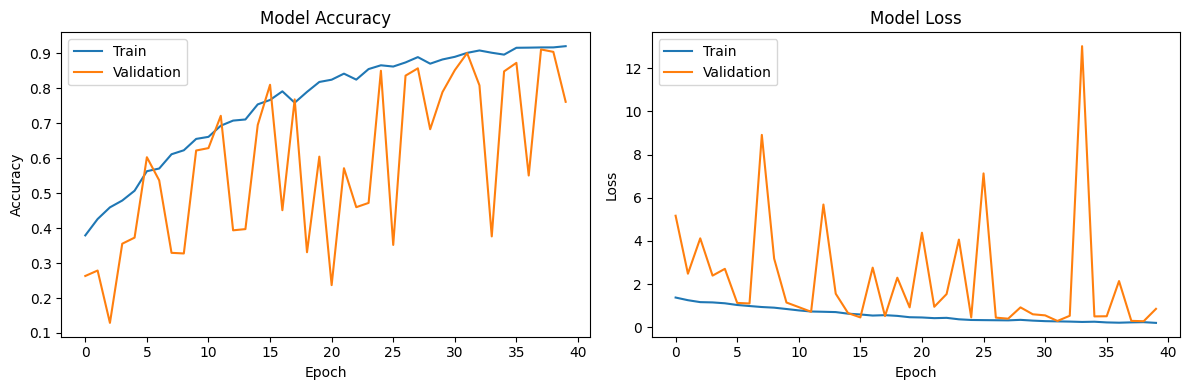

In [27]:
# train history
plt.figure(figsize=(12, 4))

# Plot training, validation
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training, validation
plt.subplot(1, 2, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

**Accuracy**

Tacnost na trening skupu raste do oko 0.9, što pokazuje da model dobro uči na trening podacima. Tacnost na validacionom skupu osciluje između 0.1 i 0.8, ali pokazuje trend ka boljem. Ove oscilacije sugerišu da model nije u stanju da konstantno dobro generalizuje na neviđene podatke, što može biti rezultat preprilagodjavanja


**Loss**

Greska na trening setu opada ispod 1, što pokazuje da model smanjuje grešku na trening podacima. Greska na validacionom skupu osciluje značajno, sa vrednostima koje se kreću između 0 i 12. Ova velika varijabilnost u validacionoj grešci ukazuje na to da model ima poteškoća u učenju stabilnih karakteristika iz validacionih podataka. Takve oscilacije mogu biti znak preprilagodjavanja, gde model dobro radi na trening podacima ali ne uspeva da generalizuje na validacioni skup.